In [51]:
# Notes to self:
# 6/2/20 - You left on working on skills cluster
# Still need to figure out what your model is really going to be . . . 

In [1]:
# Packages for EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from nltk.corpus import stopwords

# Packages for PostgreSQL Import and Export
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

# Custom packages with database connection information (Not working)
    #from projectname.config import dbname, username, pswd

In [2]:
# Ideally I'll move this into the project config.py file
# Otherwise for now I have to just manually assign . . .

dbname = "freelance_db"
username = "Metaverse"
pswd = "Arcifice91"

In [3]:
# Connect to Data (from: scraping_data.ipynb)

con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# Column reference
sql_query = """SELECT * FROM INFORMATION_SCHEMA.TABLES;"""
col_ref = pd.read_sql_query(sql_query,con)
col_ref[col_ref['table_schema'] == "public"]['table_name']

0           freelance_db
3          details_table
4         analysis_table
8     user_details_table
21       freelance_table
Name: table_name, dtype: object

In [4]:
# Checking shapes of tables
sql_query = """SELECT * from user_details_table;"""
dtls_table = pd.read_sql_query(sql_query, con)

sql_query = """SELECT * from freelance_table;"""
fl_table = pd.read_sql_query(sql_query, con)

print(dtls_table.shape)
print(fl_table.shape)

(1020, 9)
(4539, 10)


In [5]:
# Creating merged dataset
dtls_table['profile_url'] = "https://www.guru.com"+dtls_table['profile_url']

In [6]:
all_table = pd.merge(fl_table, dtls_table, on='profile_url')
all_table.shape
all_table = all_table.drop(columns=(['index_x']))
all_table = all_table.drop_duplicates(subset='profile_url')
print(all_table.shape)

(979, 17)


In [7]:
# Merging in State Regions
state_region_crswlk = pd.read_csv('~/Desktop/Insight/projects/myrate/data/raw/census-regions/us census bureau regions and divisions.csv')
state_region_crswlk.head()

all_table = pd.merge(all_table, state_region_crswlk, how='left', left_on='state', right_on='State')


In [8]:
all_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 978
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   profile_url       979 non-null    object
 1   city              979 non-null    object
 2   state             979 non-null    object
 3   country           979 non-null    object
 4   rating            979 non-null    object
 5   earnings          979 non-null    object
 6   hourly_rate       979 non-null    int64 
 7   skills_list       979 non-null    object
 8   user_description  979 non-null    object
 9   index_y           979 non-null    int64 
 10  member_since      979 non-null    object
 11  earnings_pst_yr   948 non-null    object
 12  earnings_ever     948 non-null    object
 13  employers         948 non-null    object
 14  invoices_paid     948 non-null    object
 15  largest_employ    948 non-null    object
 16  bio               948 non-null    object
 17  State           

In [9]:
# Inspecting null merges with region data
all_table[all_table['State'].isna()]
    # Ah, it is someone in Puerto Rico. Making their Region "Other"
all_table.loc[all_table['state'] == "Puerto Rico",'Region'] = "Other"

### EDA for 'all_table'

In [10]:
# Basic descriptives: Outcome - hourly_rate
all_table['hourly_rate'].mean()

31.93667007150153

In [ ]:
# Distribution
sns.distplot(all_table['hourly_rate'])

In [ ]:
# Number of different cities and states?
print("Number of cities: " + str(all_table['city'].nunique()))
print("Number of states: " + str(all_table['state'].nunique()))

In [ ]:
# All United States? Yes.
#print(all_table['state'].drop_duplicates())

In [ ]:
# Can do much much much more from here:
    # 1. Different cities
        # - rate distribution by city?
        # - Number of unique obs by city?
        # - Create a map?
    # 2. Inspect skills
        # - Number of different skills?
        # - Which skills are the most common? How does rate vary within those?
        # - Group skills (???) and calculate hourly rate 
        #   distribution by those groupings
    # 3. Inspect description
        # - Text analysis of some kind.
        # - Also will need to go back and scrape info from the user pages.
        #   Could also try Selenium but may be faster to just scrape on static page.
        #   Nvm. Will have to use Selenium.

### Inspecting the outcome (hourly rate) by state

In [ ]:
# Distribution of hourly rates by state?
sns.distplot(all_table.drop_duplicates().groupby('state').mean()['hourly_rate'])

# Pretty much a normal distrbution aside from a few outliers (who are they?)

In [ ]:
# Top five states with highest average hourly rates
print("Five states with the highest average hourly rates")
print(all_table.groupby('state').mean()['hourly_rate'].sort_values(ascending=False)[0:5,])
print("Five states wit hteh lowest average hourly rates")
print(all_table.groupby('state').mean()['hourly_rate'].sort_values(ascending=True)[0:5,])

# Well, here they are. Mississippi with a mean HR or 104! and then RI & MT ~= 70!
# Similarly have a couple of low end states: ND and AK @ ~= 8.5
# Everyone else respects the normal distribution

In [ ]:
# What are the counts within each state?
print("Counts of observations by state")
dt_tmp = all_table.groupby('state').count()['profile_url'].sort_values(ascending=False)
sns.distplot(dt_tmp)

# Ooof, really small obs in some states.

In [ ]:
# Counts within each state
print("Five states with lowest counts")
print(all_table.groupby('state').count()['profile_url'].sort_values(ascending=True)[0:5])

print("Five states with largest counts")
print(all_table.groupby('state').count()['profile_url'].sort_values(ascending=False)[0:5])

# No one in some states and alot of people in other states . . .

### Inspecting outcome by region

Note: There doesn't seem to be a signal. Could we cut this up further though? Urban vs rural?

In [ ]:
# What is the distribution by region?
sns.boxplot(x="Region", y="hourly_rate", data=all_table)

# There doesn't seem to be much of a signal by region

### Merging in City Data

Lose 114 observations. . . would take some hand recoding to get them back.

This merge isn't worth the effort right now.

In [ ]:
# Merging in City Data - https://simplemaps.com/data/us-cities    
# Data is unique at city | state_name
# city_dt = pd.read_csv('/Users/Metaverse/Desktop/Insight/projects/myrate/data/raw/simplemaps_uscities_basicv1.6/uscities.csv')
# city_dt['city'] = city_dt['city'].str.lower()
# all_table['city'] = all_table['city'].str.lower()
# all_table = pd.merge(all_table, city_dt,  how='left', left_on=['city','state'], right_on = ['city','state_name'])
# all_table.info()


### Looking at "Rating"

Not much here either.

In [11]:
# Distrbution of ratings - First I have to clean it up
all_table.rating = all_table.rating.str.replace('%','')
all_table.rating = all_table.rating.str.replace('NA','')
all_table.rating = pd.to_numeric(all_table.rating)

In [12]:
# Distribution of ratings (not there are a a good amount of NAS)
print(all_table.rating.isna().sum())
all_table.rating.describe()

68


count    911.000000
mean      98.424040
std       11.376479
min        1.000000
25%      100.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: rating, dtype: float64

In [ ]:
# All table connection to the outcome - Not very informative.
sns.scatterplot(x="hourly_rate", y="rating", data=all_table)

In [ ]:
# Distribution of ratings by region? Nope, no relation
sns.boxplot(x="Region", y="rating", data=all_table)

### How long have they been a member? And how does it relate to the number of jobs completed?

1. Convert member start date to a date object
2. Calculate years / months they've been a member (to today)

In [13]:
def date_convert(member_since):
    try:
        tmp = datetime.strptime(member_since, '%b, %Y')
        #tmp = tmp.strftime('%Y-%m')
    except:
        tmp = 'NaN'
    return tmp

In [14]:
def years_active(date):
    cur_year = datetime.now().year
    try:
        yrs_active = cur_year - date.year
    except:
        yrs_active = 'NaN'
    
    return yrs_active

In [15]:
def months_active(date):
    cur_year = datetime.now().year
    cur_month = datetime.now().month
    
    try:
        mnths_active = (cur_year - date.year)*12 + (cur_month - date.month)
    except:
        mnths_active = 'NaN'
        
    return mnths_active

In [16]:
# How many NAs are there?
all_table.member_since[all_table.member_since == 'NA'].count()

21

In [17]:
# Converting member_since to date
all_table.member_since = all_table.member_since.str.strip()
all_table['start_date'] = all_table.member_since.apply(date_convert)
all_table['years_active'] = all_table.start_date.apply(years_active)
all_table['months_active'] = all_table.start_date.apply(months_active)

In [18]:
# Checking the NAs
all_table.start_date.isna().sum()

# Just going to drop these people for now (later when creating analysis data)

31

In [ ]:
# Exploring distribution of years active
sns.distplot(all_table.years_active)

In [ ]:
# Exploring distribution of months active
sns.distplot(all_table.months_active)

In [ ]:
# Discussing distributions of years active
    # Pretty similar, heavy towards the low end with some people
    # who have been active for a very long time.



In [ ]:
# How does it compare with hourly rate? Not much there.
sns.scatterplot(x = 'hourly_rate', y = 'years_active', data = all_table)

In [ ]:
sns.scatterplot(x = 'hourly_rate', y = 'months_active', data = all_table)

In [ ]:
# What about by region? I don't think there would be much here. Not worth the investment.

### Moving on to invoices rate

In [19]:
# What about the (obvious) relationship between memebershp time and # of jobs completed
# How strong is the relationship?
# First have to clean the invoices paid variable
all_table.invoices_paid = all_table.invoices_paid.str.replace(',','')
all_table.invoices_paid = pd.to_numeric(all_table.invoices_paid)
all_table.invoices_paid.describe()

count     948.000000
mean       91.079114
std       405.295216
min         1.000000
25%         3.000000
50%        11.500000
75%        54.250000
max      9802.000000
Name: invoices_paid, dtype: float64

In [20]:
# Who is NA? I have a whole bunch of 1s but then some NAs?
# The question for a poisson model is: did they just have no invoices OR
# were they never going to have any invoices.
# Looked at some of them and I'll treat them as zeros. So there are really that many ones?!?
all_table[all_table.invoices_paid.isna()].head()

,profile_url,city,state,country,rating,earnings,hourly_rate,skills_list,user_description,index_y,...,invoices_paid,largest_employ,bio,State,State Code,Region,Division,start_date,years_active,months_active
947,https://www.guru.com/freelancers/melvis-molindo,Adelphi,Maryland,United States,NaN,NA,13,Customer Service,Seeking to obtain a rewarding and challenging ...,8,...,NaN,None,None,Maryland,MD,South,South Atlantic,NaT,NaN,NaN
948,https://www.guru.com/freelancers/earl-rouse,New York,New York,United States,NaN,NA,25,Photography,A New York City Photographer specializing in e...,9,...,NaN,None,None,New York,NY,Northeast,Middle Atlantic,NaT,NaN,NaN
949,https://www.guru.com/freelancers/jacquetta-bom...,Dunwoody,Georgia,United States,NaN,NA,10,Admin Assistant,I have over 6 1/2 years of experience in the ...,10,...,NaN,None,None,Georgia,GA,South,South Atlantic,NaT,NaN,NaN
950,https://www.guru.com/freelancers/shelley-jennings,Chicago,Illinois,United States,NaN,NA,13,Administrative Assistant,Over 45 years of experience in customer suppor...,11,...,NaN,None,None,Illinois,IL,Midwest,East North Central,NaT,NaN,NaN
951,https://www.guru.com/freelancers/brian-pegram,Hernando,Mississippi,United States,NaN,NA,200,Penetration Testing,This is the first in a series of Penetration ...,12,...,NaN,None,None,Mississippi,MS,South,East South Central,NaT,NaN,NaN


In [21]:
# Assigning zero to the NAs. This is important!!
all_table.loc[all_table.invoices_paid.isna(), 'invoices_paid'] = 0

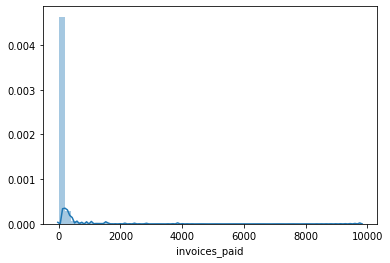

In [22]:
sns.distplot(all_table.invoices_paid)

In [23]:
# Wow, very heavy on the zeros. Let's look closer.
all_table.invoices_paid.describe()

count     979.000000
mean       88.195097
std       399.139186
min         0.000000
25%         2.000000
50%        10.000000
75%        50.000000
max      9802.000000
Name: invoices_paid, dtype: float64

In [ ]:
# Ah, so it is truncating at one.
# This is going to be problematic for those who are actually at a value of one.
# I can either rerun the scrape and create something to make the val = 0
# or I can just move forward. . . 

# For now I'm going to keep moving forward and treat 1 as 0.
# Note, it is more likely than not that they are = 0

In [ ]:
# Checking dist vs months active (no 1s)
sns.scatterplot(x = 'months_active', y = 'invoices_paid', data = all_table[all_table.invoices_paid > 1])

In [ ]:
# A few massive outliers. Going to rough chop it down and replot
invoice_gtr_one = all_table.invoices_paid > 1
invoice_ls_2000 = all_table.invoices_paid < 2000
sns.scatterplot(x = 'months_active', y = 'invoices_paid', data = all_table[invoice_gtr_one & invoice_ls_2000])

In [ ]:
# hmm, there may be a slight signal but you would expect a stronger trend

In [ ]:
# Checking dist vs years active (no 1s)
sns.scatterplot(x = 'years_active', y = 'invoices_paid', data = all_table[invoice_gtr_one & invoice_ls_2000])
# Slight postive non-linear trend bu there is a HUGE outlier

### Invoices Paid - Notes

It has a weak-ish relationship with time. There are a lot of really heavy users of the platform that dominate the market. Let's zoom into the first year and see what it looks like.

In [ ]:
# Looking at invoices pad in the first few months (among those only active for a shorter period of time)
sns.scatterplot(x = 'months_active',
                y = 'invoices_paid',
                data = all_table[all_table['years_active'] < 2] )

count    948.000000
mean       1.073220
std        2.652725
min        0.004237
25%        0.113167
50%        0.333333
75%        1.000000
max       48.285714
Name: invoices_per_month, dtype: float64


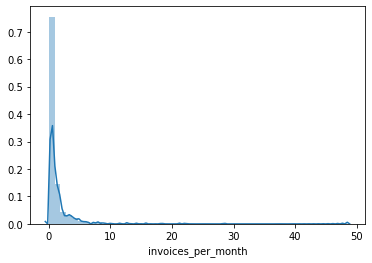

In [22]:
# Calculating invoices / time active
all_table['invoices_per_month'] = all_table['invoices_paid']/all_table['months_active']
sns.distplot(all_table.invoices_per_month)
print(all_table.invoices_per_month.describe())

In [ ]:
# Loaded on zero with a long tail. Continues to sell that there are some serious power users.
# Average invoice per month is equal to one, but I left in the 1s that could be zeros. . .
# Real average is likely near zero.

# The question now is: Does this mean differ by any characteristic that I observe in the data?
# For people with a different skill set (Andriod) do they have a higher mean invoice/month rate?
# For people in different regions do they have a higher mean invoice/month rate?
# For people with lower hourly rates do they have a higher mean invoice/month rate??

# The next important step is to figure out how to use the skills data.
# It would be great to try and create clusters of the skills.

### Working with Skills Data

1. Obtain the dataset that is long by skills and shrink it down to just the skills. I'll work with that for this.
2. Create some quick features such as: # of skills and top skill. These are user level so I can attach them back to all_table to have everything in one place.

Note: the skills are standardized on guru which makes this more straightforward

In [44]:
sql_query = """SELECT profile_url, skills_list from freelance_table;"""
skills_table = pd.read_sql_query(sql_query, con)
skills_table_dummies = pd.get_dummies(skills_table, columns=['skills_list']).groupby(['profile_url'], as_index=False).sum()

In [45]:
# Number of skills
num_skills = skills_table.groupby('profile_url').count()
num_skills.skills_list.describe()

# Relatively uninformative because everyone maxes out the number of skilsl they can have.
# However, I may be able to get some predictive power off the small group of people who have < 5 skills.

count    979.000000
mean       4.636364
std        0.940209
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: skills_list, dtype: float64

In [46]:
# Flagging those with < 5 skills
num_skills['less_five_skills'] = (num_skills.skills_list < 5) * 1

In [47]:
# Extracting First Skill
first_skill = skills_table[skills_table.groupby('profile_url')['skills_list'].cumcount() == 0]
first_skill = first_skill.rename(columns = {"profile_url":"profile_url", "skills_list":"first_skill"})
first_skill.head()

,profile_url,first_skill
0,https://www.guru.com/freelancers/scopic,Angular
5,https://www.guru.com/freelancers/top-guru-assi...,Android
10,https://www.guru.com/freelancers/eden-programm...,Android
15,https://www.guru.com/freelancers/avion-technol...,.NET
20,https://www.guru.com/freelancers/j-consulting,.NET


In [48]:
num_skills = pd.merge(num_skills, first_skill, on = 'profile_url')
num_skills.head()

,profile_url,skills_list,less_five_skills,first_skill
0,https://www.guru.com/freelancers/35-year-edito...,5,0,Book Editing
1,https://www.guru.com/freelancers/64c-it-services,5,0,.NET
2,https://www.guru.com/freelancers/7-design-group,5,0,Adobe InDesign
3,https://www.guru.com/freelancers/86-keys-commu...,5,0,Acrobat
4,https://www.guru.com/freelancers/a-few-wordsworth,5,0,Acting


In [30]:
# Merging into all_table
all_table = pd.merge(all_table, num_skills, on = "profile_url")

### Working on clustering the skills

In [ ]:
# Working with the skills dummies: Clustering
    # K-means is for numeric data
    # Frequent item sets seems to be a good one?
    # What I want to do is group people with similar vectors . . 
    # So the position of their ones are exactly the same . . .
    # Kernel? 

### Starting the process of using the "bio" data

1. The easiest variable to create is the len(bio)
2. I'll have to try and expand it more using some other techniques

In [87]:
def clean_bio(bio):
    try:
        cleaned_bio = ''.join(s for s in bio if ord(s)>31 and ord(s)<126)
    except:
        cleaned_bio = "NaN"
    return cleaned_bio

In [88]:
def len_bio(bio):
    if bio == "NaN":
        return 0
    else:
        return len(bio)

In [89]:
all_table['bio_clean'] = all_table.bio.apply(clean_bio)

In [90]:
all_table['bio_length'] = all_table.bio_clean.apply(len_bio)

In [ ]:
# Looking at the distrbution of bio lengths
sns.distplot(all_table.bio_length)

# Nothing crazy, lots of 0s but a good number of people with bios.

In [ ]:
# How does it relate to invoices / month?
sns.scatterplot(x = 'bio_length',
                y = 'invoices_per_month',
                data = all_table)

# It's weak but I'll keep it for now

In [110]:
# Number of separate words in bio
all_table['bio_word_count'] = all_table['bio_clean'].apply(lambda x: len(str(x).split(" ")))

In [94]:
# Average word length in bio
def avg_word_ln(bio):
    try:
        words = bio.split()
        res = (sum(len(word) for word in words)/len(words))
    except:
        res = 0
    return res

In [95]:
all_table['avg_word_length'] = all_table['bio_clean'].apply(avg_word_ln)

In [96]:
# Number of stop words
def num_stopwords(bio):
    stop = stopwords.words('english')

    try:
        res = len([x for x in bio.split() if x in stop])
    except:
        res = -1
    
    return res

In [97]:
all_table['num_stop'] = all_table['bio_clean'].apply(num_stopwords)

In [112]:
# Preprocessing before pulling more features

# Remvoing stop words
stop = stopwords.words('english')
all_table['bio_processed'] = all_table['bio_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# Removing punctuation
all_table['bio_processed'] = all_table['bio_processed'].str.replace('[^\w\s]','')

# Lower Case
all_table['bio_processed'] = all_table['bio_processed'].apply(lambda x: " ".join(x.lower() for x in x.split()))

### Some final cleaning

In [ ]:
# Making Region into dummy variables
region_dummies = pd.get_dummies(all_table['Region'])
all_table = pd.concat([all_table, region_dummies], axis = 1)

In [131]:
# Earnings per Month
all_table['earnings_ever'] = all_table['earnings_ever'].str.replace('$','')
all_table['earnings_ever'] = all_table['earnings_ever'].str.replace(',','')
all_table['earnings_ever'] = pd.to_numeric(all_table['earnings_ever'])
all_table['earnings_pr_month'] = all_table['earnings_ever']/all_table['months_active']

### Saving out Modified Dataset

1. First printing the columns I have for reference.
2. Saving it to a new table in the postgreSQL database

In [133]:
all_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 978
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   profile_url         979 non-null    object        
 1   city                979 non-null    object        
 2   state               979 non-null    object        
 3   country             979 non-null    object        
 4   rating              911 non-null    float64       
 5   earnings            979 non-null    object        
 6   hourly_rate         979 non-null    int64         
 7   skills_list_x       979 non-null    object        
 8   user_description    979 non-null    object        
 9   index_y             979 non-null    int64         
 10  member_since        979 non-null    object        
 11  earnings_pst_yr     948 non-null    object        
 12  earnings_ever       948 non-null    float64       
 13  employers           948 non-null    object        

In [135]:
# Cleaning to just variables that will be used in the model
analysis_dt = all_table[['invoices_per_month','hourly_rate','earnings_pst_yr','earnings_pr_month',
                         'Midwest','Northeast','South','Other','West','less_five_skills','bio_length',
                         'bio_word_count', 'avg_word_length', 'num_stop', 'bio_processed']]
analysis_dt = analysis_dt.dropna() # Removing people with NA
analysis_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 948 entries, 0 to 978
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   invoices_per_month  948 non-null    float64
 1   hourly_rate         948 non-null    int64  
 2   earnings_pst_yr     948 non-null    object 
 3   earnings_pr_month   948 non-null    float64
 4   Midwest             948 non-null    uint8  
 5   Northeast           948 non-null    uint8  
 6   South               948 non-null    uint8  
 7   Other               948 non-null    uint8  
 8   West                948 non-null    uint8  
 9   less_five_skills    948 non-null    int64  
 10  bio_length          948 non-null    int64  
 11  bio_word_count      948 non-null    int64  
 12  avg_word_length     948 non-null    float64
 13  num_stop            948 non-null    int64  
 14  bio_processed       948 non-null    object 
dtypes: float64(3), int64(5), object(2), uint8(5)
memory usage

In [136]:
# Connect to the database and save data to it
engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

In [137]:
analysis_dt.to_sql("analysis_table", engine, if_exists='replace')